# To train a model to detect simples(or genericals) and complex queries 

## data prepreparation, tokenization, and model loading

In [34]:
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# --- 1. Définition du dataset ---
data = {
    "queries": [
        "Hello !",
        "How to create a CPS user session ?",
        "Hi",
        "Tell me about the CPS",
        "What is the CPS",
        "Tell me more about it ?",
        "What's going ?",
        "Tell me more",
        "How are you ?",
        "It doesn't work",
        "Who are you ?",
        "Who create you ?",
        "Where is Paris ?",
        "What is the architecture to minimize maintenance options ?",
        "What about IPSEC policy ?",
        "Do you know something about SMB v1 disabled ?",
        "I want to create a CPS session user for windows, how can I do ?",
        "The CPS server doesn't work and i want to know why ?",
        # Exemples supplémentaires
        "Good morning, how can I help you?",
        "What's the current status of the CPS?",
        "Could you explain how CPS works?",
        "Show me the troubleshooting guide for CPS errors.",
        "Hi, what's new today?",
        "I'm having issues connecting to the VPN, can you assist?",
        "Is there a maintenance window scheduled for the CPS?",
        "Thank you",
        "Bye",
        "When was the last update to the CPS documentation?",
        "What steps do I need to follow to reset the CPS password?",
        "Can you write me python code for the product of two numbers",
        "Can you write me python code for the sum of two numbers",
        "write me python code for the division of two numbers",
        "Can you write me python code for the substraction of two numbers",
        "write me python code for the modulo of two numbers",
        "Tell me something on Paris",
        "Did you United States of America ?",
        "What is the capiltal of United Kingdom ?",
        "Tell me something on the capital of France",
        "Tell me something on the capital of Germany"
    ],
    "types": [
        "simple",    # Hello !
        "complex",   # How to create a CPS user session ?
        "simple",    # Hi
        "complex",   # Tell me about the CPS
        "complex",   # What is the CPS
        "complex",   # Tell me more about it ?
        "simple",    # What's going ?
        "complex",   # Tell me more
        "simple",    # How are you ?
        "complex",   # It doesn't work
        "simple",    # Who are you ?
        "simple",    # Who create you ?
        "simple",    # Where is Paris ?
        "complex",   # What is the architecture to minimize maintenance options ?
        "complex",   # What about IPSEC policy ?
        "complex",   # Do you know something about SMB v1 disabled ?
        "complex",   # I want to create a CPS session user for windows, how can I do ?
        "complex",   # The CPS server doesn't work and i want to know why ?
        # Labels pour les exemples supplémentaires
        "simple",    # Good morning, how can I help you?
        "complex",   # What's the current status of the CPS?
        "complex",   # Could you explain how CPS works?
        "complex",   # Show me the troubleshooting guide for CPS errors.
        "simple",    # Hi, what's new today?
        "complex",   # I'm having issues connecting to the VPN, can you assist?
        "complex",   # Is there a maintenance window scheduled for the CPS?
        "simple",    # Thank you
        "simple",    # Bye
        "complex",   # When was the last update to the CPS documentation?
        "complex",   # What steps do I need to follow to reset the CPS password?
        "simple",
        "simple",
        "simple",
        "simple",
        "simple",
        "simple",
        "simple",
        "simple",
        "simple",
        "simple"
    ]
}

# --- 2. Préparation des labels ---
# Mapping : simple -> 0, complex -> 1
label_mapping = {"simple": 0, "complex": 1}
labels = [label_mapping[label] for label in data["types"]]

# --- 3. Division en ensembles d'entraînement et de validation ---
queries_train, queries_val, labels_train, labels_val = train_test_split(
    data["queries"], labels, test_size=0.2, random_state=42
)

# --- 4. Tokenization ---
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenisation des données d'entraînement et de validation
train_encodings = tokenizer(queries_train, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(queries_val, truncation=True, padding=True, max_length=128)

# Création d'un générateur pour tf.data.Dataset
def gen_train():
    for i in range(len(queries_train)):
        yield {key: train_encodings[key][i] for key in train_encodings}, labels_train[i]

def gen_val():
    for i in range(len(queries_val)):
        yield {key: val_encodings[key][i] for key in val_encodings}, labels_val[i]

# Création des datasets
train_dataset = tf.data.Dataset.from_generator(
    gen_train,
    output_signature=(
        {
            "input_ids": tf.TensorSpec(shape=(None,), dtype=tf.int32),
            "attention_mask": tf.TensorSpec(shape=(None,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).shuffle(30).batch(8)

val_dataset = tf.data.Dataset.from_generator(
    gen_val,
    output_signature=(
        {
            "input_ids": tf.TensorSpec(shape=(None,), dtype=tf.int32),
            "attention_mask": tf.TensorSpec(shape=(None,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(8)

# --- 5. Chargement et compilation du modèle ---
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

## model training

In [35]:

# --- 6. Entraînement du modèle avec validation et récupération de l'historique ---
history = model.fit(train_dataset, epochs=3, validation_data=val_dataset)


Epoch 1/3
4/4 [==============================] - 15s 1s/step - loss: 0.6995 - accuracy: 0.4839 - val_loss: 0.6342 - val_accuracy: 0.8750
Epoch 2/3
4/4 [==============================] - 2s 609ms/step - loss: 0.6386 - accuracy: 0.7097 - val_loss: 0.5529 - val_accuracy: 1.0000
Epoch 3/3
4/4 [==============================] - 2s 600ms/step - loss: 0.4972 - accuracy: 0.9355 - val_loss: 0.4306 - val_accuracy: 1.0000


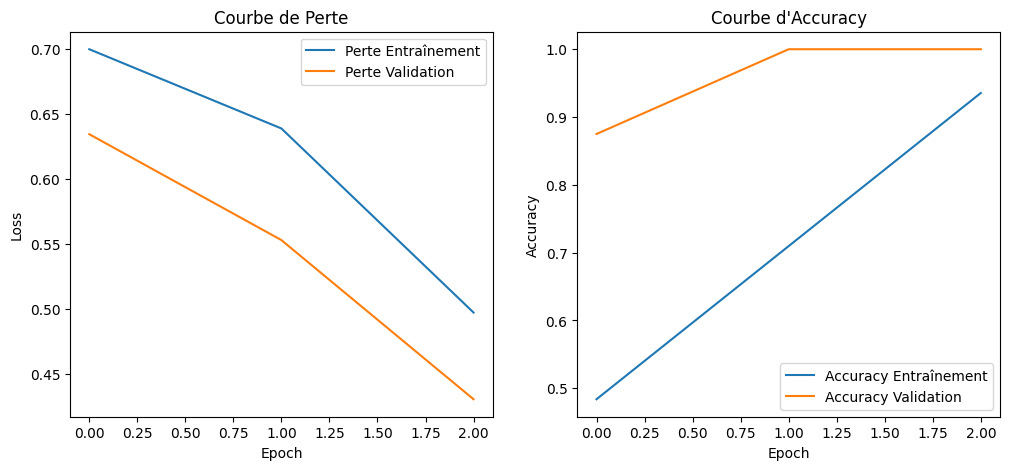

In [36]:

# --- 7. Affichage de la courbe d'apprentissage ---
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte Entraînement')
plt.plot(history.history['val_loss'], label='Perte Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Courbe de Perte")

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy Entraînement')
plt.plot(history.history['val_accuracy'], label='Accuracy Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Courbe d'Accuracy")

plt.show()


In [37]:

# --- 8. Évaluation sur l'ensemble de validation ---
eval_result = model.evaluate(val_dataset)
print("Résultat de l'évaluation sur le dataset de validation :", eval_result)

# --- 9. Test du modèle sur quelques exemples personnalisés ---
test_examples = [
    "Hello, how are you?",
    "I need help with creating a CPS session",
    "What is the system's architecture?",
    "Goodbye"
]

# Tokenisation et prédiction
test_encodings = tokenizer(test_examples, truncation=True, padding=True, max_length=128, return_tensors="tf")
outputs = model(test_encodings)
logits = outputs.logits
predicted_labels = tf.argmax(logits, axis=1).numpy()

# Mapping inverse pour afficher les labels sous forme de chaîne
inv_label_mapping = {v: k for k, v in label_mapping.items()}
for query, label in zip(test_examples, predicted_labels):
    print(f"Query: '{query}' => Label prédit: {inv_label_mapping[label]}")


1/1 [==============================] - 0s 150ms/step - loss: 0.4306 - accuracy: 1.0000
Résultat de l'évaluation sur le dataset de validation : [0.4306457042694092, 1.0]
Query: 'Hello, how are you?' => Label prédit: simple
Query: 'I need help with creating a CPS session' => Label prédit: complex
Query: 'What is the system's architecture?' => Label prédit: complex
Query: 'Goodbye' => Label prédit: simple


In [39]:
# --- 10. Fonction pour obtenir le type de requête ---
def get_query_type(query):
    encoding = tokenizer(query, truncation=True, padding=True, max_length=128, return_tensors="tf")
    outputs = model(encoding)
    logits = outputs.logits
    predicted_label = tf.argmax(logits, axis=1).numpy()[0]
    inv_label_mapping = {0: "simple", 1: "complex"}
    return inv_label_mapping[predicted_label]


In [47]:
get_query_type("i want to know what is SMV")

'complex'

In [48]:
# Save the model and tokenizer in a directory called "saved_model"
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")


('saved_model\\tokenizer_config.json',
 'saved_model\\special_tokens_map.json',
 'saved_model\\vocab.txt',
 'saved_model\\added_tokens.json',
 'saved_model\\tokenizer.json')